In [1]:
!pip install kaggle


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [3]:
!kaggle datasets download -d antoreepjana/animals-detection-images-dataset -p /content/data --unzip


Dataset URL: https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset
License(s): CC0-1.0
100% 8.91G/8.92G [01:40<00:00, 198MB/s]
100% 8.92G/8.92G [01:40<00:00, 95.4MB/s]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
save_path = '/content/drive/My Drive/animals-dataset'

In [6]:
import os

target_path = '/content/drive/My Drive/animals-dataset'
os.makedirs(target_path, exist_ok=True)

In [10]:
import shutil

source_path_train = '/content/data/train/'
source_path_test = '/content/data/test/'

target_path_train = os.path.join(target_path, 'train')
target_path_test = os.path.join(target_path, 'test')

os.makedirs(target_path_train, exist_ok=True)
os.makedirs(target_path_test, exist_ok=True)

# List of folders to upload
folders = ['Cheetah', 'Fox', 'Jaguar', 'Lion', 'Tiger']

# Copy train folders
for folder in folders:
    shutil.copytree(os.path.join(source_path_train, folder), os.path.join(target_path_train, folder))

# Copy test folders
for folder in folders:
    shutil.copytree(os.path.join(source_path_test, folder), os.path.join(target_path_test, folder))

print("Selected folders have been uploaded to Google Drive!")

Selected folders have been uploaded to Google Drive!


In [3]:
!pip install ultralytics
!yolo checks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 23.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)

OS                  Linux-6.1.85+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 12.67 GB
Disk                32.6/112.6 GB
CPU                 Intel Xeon 2.00GHz
CPU count           2
GPU                 Tesla T4, 15102MiB
GPU count           1
CUDA                12.1

numpy               ✅ 1.26.4>=1.23.0
numpy               ✅ 1.26.4<2.0.0; sys_platform == "darwin"
matplotlib          ✅ 3

In [4]:
import os
import random
import shutil
from collections import defaultdict, Counter
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Iterable
import yaml

import cv2
import plotly.express as px
from plotly import subplots
from tqdm.notebook import tqdm
import torch
from ultralytics import YOLO

In [17]:
DATASET_PATH = '/content/drive/MyDrive/animals-dataset'  # Path to source dataset
MASTER_PATH = '/content/drive/MyDrive/animals-dataset-processed'  # Path where all outputs are stored (intermediate and final)
DEBUG = False # Activete to run notebook faster
CPU = False

#if not CPU:
#    assert torch.cuda.is_available(), 'CUDA not found!'

In [18]:
class LookupTable:
    """Vocabulary - Label lookup table (token <-> index)."""
    def __init__(
        self,
        token_to_index: Optional[Dict[str, int]] = None,
        unknown_token: str = '<unk>',
        add_unknown_token: bool = True
    ):
        """
        Args:
            token_to_index: Predefine token to index mappings.
            unknown_token: Unknown token value.
            add_unknown_token: Use unknown token.
        """
        self._token_to_index = token_to_index
        self._unknown_token = unknown_token
        self._add_unknown_token = add_unknown_token

        if self._token_to_index is None:
            self._token_to_index = {}

        if unknown_token not in self._token_to_index and add_unknown_token:
            self._token_to_index[unknown_token] = len(self._token_to_index)

        self._index_to_token = {v: k for k, v in self._token_to_index.items()}
        self._next_index = len(self._token_to_index)

    def add(self, token: str) -> int:
        """
        Adds token to the lookup table if it does not already exist.

        Args:
            token: Label (token)

        Returns:
            label (token) index
        """
        if token in self._token_to_index:
            return self._token_to_index[token]

        new_index = self._next_index
        self._next_index += 1
        self._token_to_index[token] = new_index
        self._index_to_token[new_index] = token
        return new_index

    def lookup(self, token: str) -> int:
        """
        Acquires token index if it exists in the table.
        In case the token does not exist in the lookup table:
            - and unknown token is used then unkown token index is returned;
            - otherwise KeyError is raised

        Raises:
            KeyError: Unknown token

        Returns:
            label (token) index
        """
        if token not in self._token_to_index and self._add_unknown_token:
            return self._token_to_index[self._unknown_token]

        return self._token_to_index[token]

    def inverse_lookup(self, index: int) -> str:
        """
        Inverse to `lookup`. Acquire token by index.

        Raises:
            KeyError: Unknown index

        Returns:
            label (token)
        """
        return self._index_to_token[index]

    def __iter__(self) -> Iterable[Tuple[str, int]]:
        for token, index in self._token_to_index.items():
            yield token, index

    def __getitem__(self, token: str) -> int:
        return self.lookup(token)  # Alias for `lookup`

    def __len__(self):
        return self._next_index

In [19]:
DatasetIndex = Dict[str, Dict[str, List[str]]]
DatasetStats = Dict[str, int]


class AnimalToYOLODatasetAdapter:
    """Adapts custom animal dataset to YOLO format."""
    def __init__(self, path: str, label_filter: Optional[List[str]] = None):
        """
        Args:
            path: Path where dataset is stored
            label_filter: Use specific set of labels (remove others from dataset)
        """
        self._path = path

        self._index, self.label_stats, self.split_stats, self.label_lookup, self._size = \
            self._index_dataset(path, label_filter)

    @staticmethod
    def _index_dataset(path: str, label_filter: Optional[List[str]] = None) \
        -> Tuple[DatasetIndex, DatasetStats, DatasetStats, LookupTable, int]:
        """
        Creates datast index. Index is mapping (split -> label -> sample_id).
        Input dataset format is given in previosly defined structure.

        Args:
            path: Dataset path
            label_filter: Filter used labels

        Returns:
            Dataset index, Label stats, Split stats, dataset size
        """
        index: DatasetIndex = defaultdict(dict)
        label_stats: DatasetStats = Counter()
        split_stats: DatasetStats = Counter()
        lookup = LookupTable(add_unknown_token=False)
        size = 0

        splits = os.listdir(path)
        for split in splits:
            split_path = os.path.join(path, split)
            labels = os.listdir(split_path)
            for label in tqdm(labels, desc=f'Indexing {split}', unit='sample'):
                if label_filter is not None and label not in label_filter:
                    continue

                label_path = os.path.join(split_path, label)
                sample_ids = [Path(filename).stem for filename in os.listdir(label_path)
                              if filename != 'Label' and filename.endswith('.jpg')]
                annotations_path = os.path.join(label_path, 'Label')
                annot_sample_ids = [Path(filename).stem for filename in os.listdir(annotations_path)
                                    if filename.endswith('.txt')]
                assert set(sample_ids) == set(annot_sample_ids), 'Image sample ids and annotation sample ids do not match'

                # Update index, stats and lookup
                index[split][label] = sample_ids

                n_samples = len(sample_ids)
                label_stats[label] += n_samples
                split_stats[split] += n_samples
                size += n_samples

                lookup.add(label)

        return dict(index), dict(label_stats), dict(split_stats), lookup, size

    def __len__(self) -> int:
        return self._size

    @property
    def labels(self) -> List[str]:
        """
        Returns:
            List of labels (classes) in lookup table
        """
        return list(self.label_lookup)

    @property
    def n_labels(self) -> int:
        """
        Returns:
            Number of labels (classes) in lookup table
        """
        return len(self.label_lookup)

    def get_random_samples(self, n: int, split: str = 'train') -> List[Tuple[str, str, str]]:
        """
        Fetchen `n` random samples from dataset for chosen split.

        Args:
            n: Number of samples
            split: chosen split

        Returns:
            List of tuples (split, label, sample_id)
        """
        split_index = self._index[split]
        label_names, _ = zip(*self.labels)

        result: List[Tuple[str, str, str]] = []
        for i in range(n):
            label = random.choice(label_names)
            sample_ids = split_index[label]
            sample_id = random.choice(sample_ids)
            result.append((split, label, sample_id))

        return result

    def get_split_size(self, split: str) -> int:
        """
        Returns:
            Number of samples in split
        """
        return self.split_stats[split]

    def get_image_path(self, split: str, label: str, sample_id: str) -> str:
        """
        Animal dataset image path convention.

        Args:
            split: Split
            label: Label (token)
            sample_id: Sample id

        Returns:
            Image path
        """
        return os.path.join(self._path, split, label, f'{sample_id}.jpg')

    def load_image(self, split: str, label: str, sample_id: str) -> str:
        """
        Args:
            split: Split
            label: Label (token)
            sample_id: Sample id

        Returns:
            Loaded image
        """
        image_path = self.get_image_path(split, label, sample_id)
        if not os.path.exists(image_path):
            raise FileNotFound(f'Image "{image_path}" not found!')
        return cv2.imread(image_path)

    def get_annot_path(self, split: str, label: str, sample_id: str) -> str:
        """
        Animal dataset annotation path convention.

        Args:
            split: Split
            label: Label (token)
            sample_id: Sample id

        Returns:
            Annotation path
        """
        return os.path.join(self._path, split, label, 'Label', f'{sample_id}.txt')

    def parse_annot(self, split: str, label: str, sample_id: str) \
        -> List[Tuple[str, float, float, float, float]]:
        """
        Parses annotation (ground truth) file.

        Args:
            split: Split
            label: Label (token)
            sample_id: Sample id

        Returns:
            Parsed annotations
        """
        annot_path = self.get_annot_path(split, label, sample_id)
        with open(annot_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        annots: List[Tuple[str, float, float, float, float]] = []
        for l in lines:
            items = l.split()
            label_name = ' '.join(items[:-4])
            coords = [float(v) for v in items[-4:]]
            annots.append([label_name, *coords])
        return annots

    def convert(self, path: str) -> None:
        """
        Converts dataset tp YOLO format.

        Args:
            path: Output path
        """
        for split in self._index:
            split_path = os.path.join(path, split)
            images_path = os.path.join(split_path, 'images')
            labels_path = os.path.join(split_path, 'labels')
            Path(images_path).mkdir(parents=True, exist_ok=True)
            Path(labels_path).mkdir(parents=True, exist_ok=True)

            for label, sample_ids in tqdm(self._index[split].items(), desc='Converting to Yolo format', total=len(self._index[split])):
                assert len(sample_ids) == len(set(sample_ids))
                for sample_id in sample_ids:
                    image_path = self.get_image_path(split, label, sample_id)
                    new_image_path = os.path.join(images_path, f'{sample_id}.jpg')
                    annots = self.parse_annot(split, label, sample_id)
                    new_annot_path = os.path.join(labels_path, f'{sample_id}.txt')

                    # Image needs to be loaded in order to read width and height
                    # which are required for coordinate normalization
                    image = self.load_image(split, label, sample_id)
                    h, w, _ = image.shape

                    # Conversion
                    converted_annot: List[Tuple[int, float, float, float, float]] = []
                    for label, x_min, y_min, x_max, y_max in annots:
                        label_index = self.label_lookup[label]
                        x_center = (x_min + x_max) / (2 * w)
                        y_center = (y_min + y_max) / (2 * h)
                        width = (x_max - x_min) / w
                        height = (y_max - y_min) / h

                        converted_annot.append((label_index, x_center, y_center, width, height))

                    # Save data
                    with open(new_annot_path, 'a', encoding='utf-8') as f:
                        converted_annot_lines = [' '.join([str(v) for v in row]) for row in converted_annot]
                        f.write('\n'.join(converted_annot_lines))
                        f.write('\n')

                    if not os.path.exists(new_image_path):
                        shutil.copy(image_path, new_image_path)


adapter = AnimalToYOLODatasetAdapter(
    path=DATASET_PATH,
    label_filter=['Tiger'] if DEBUG else None
)

print(f'Total number of samples in the dataset is {len(adapter)}.')
print(f'Total number of classes in the dataset is {adapter.n_labels}.')
print(f'Train dataset size is {adapter.get_split_size("train")} (images). Test dataset size is {adapter.get_split_size("test")} (images)')

Indexing train:   0%|          | 0/5 [00:00<?, ?sample/s]

Indexing test:   0%|          | 0/5 [00:00<?, ?sample/s]

Total number of samples in the dataset is 1169.
Total number of classes in the dataset is 5.
Train dataset size is 901 (images). Test dataset size is 268 (images)


In [20]:
fig = px.histogram(x=list(adapter.label_stats.keys()), y=list(adapter.label_stats.values())) \
        .update_layout(xaxis_title="Class", yaxis_title="Class size", xaxis={'categoryorder':'total descending'})
fig.show()

In [21]:
def visualize_samples(
    adapter: AnimalToYOLODatasetAdapter,
    n_rows: int,
    n_cols: int,
    bbox_color: Tuple[int, int, int] = (255, 0, 0),  # RBG - RED
    model: Optional[YOLO] = None
) -> None:
    """
    Visualizes image sample with ground truths and (optionally) model predictions.
    Number of images is equal to product of `n_rows` and `n_cols`

    Args:
        adapter: Animal dataset to YOLO adapter
        n_rows: Number of rows in image matrix
        n_cols: Number of cols in image matrix
        bbox_color: Ground truth bbox color
        model: Model to generate prediction for given images
    """
    n: int = n_rows * n_cols

    viz_samples = adapter.get_random_samples(n)
    fig = subplots.make_subplots(rows=n_rows, cols=n_cols)
    for plot_index, (split, label, sample_id) in enumerate(viz_samples):
        row = plot_index // n_cols + 1
        col = plot_index % n_cols + 1
        image = adapter.load_image(split, label, sample_id)
        label_index = adapter.label_lookup.lookup(label)

        # Visualize ground truth
        for _, x_min, y_min, x_max, y_max in adapter.parse_annot(split, label, sample_id):
            x_min, y_min, x_max, y_max = [int(v) for v in [x_min, y_min, x_max, y_max]]
            labek_text = f'{label} ({label_index})'
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=bbox_color, thickness=4)
            image = cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, bbox_color, 3)

        if model is not None:
            # Visualize model predictions
            prediction = model.predict([image], imgsz=512, conf=0.3)
            for p in prediction:
                image = p.plot()

        subfig = px.imshow(image)
        fig.add_trace(subfig.data[0], row=row, col=col)

    fig = fig.update_xaxes(showticklabels=False)
    fig = fig.update_yaxes(showticklabels=False)
    fig = fig.update_layout(
        autosize=False,
        width=1200,
        height=600
    )
    fig.show()

visualize_samples(adapter, 1, 3)

In [22]:
adapter.convert(MASTER_PATH)

Converting to Yolo format:   0%|          | 0/5 [00:00<?, ?it/s]

Converting to Yolo format:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
import os
import random
import shutil

# Paths
data_path = '/content/drive/MyDrive/animals-dataset-processed/test/images'
label_path = '/content/drive/MyDrive/animals-dataset-processed/test/labels'
test_img_path = '/content/drive/MyDrive/animals-dataset-processed/test/images'
val_img_path = '/content/drive/MyDrive/animals-dataset-processed/val/images'
test_label_path = '/content/drive/MyDrive/animals-dataset-processed/test/labels'
val_label_path = '/content/drive/MyDrive/animals-dataset-processed/val/labels'

# Create directories if they don't exist
os.makedirs(test_img_path, exist_ok=True)
os.makedirs(val_img_path, exist_ok=True)
os.makedirs(test_label_path, exist_ok=True)
os.makedirs(val_label_path, exist_ok=True)

# List all images
images = [f for f in os.listdir(data_path) if f.endswith('.jpg')]
random.shuffle(images)

# Split (50% test, 50% val)
train_size = int(0.5 * len(images))

train_images = images[:train_size]
val_images = images[train_size:]

# Move files
for img in val_images:
    shutil.move(os.path.join(data_path, img), val_img_path)
    label_file = img.replace('.jpg', '.txt')
    shutil.move(os.path.join(label_path, label_file), val_label_path)

print("Dataset split completed!")

Dataset split completed!


In [25]:
import os

# Base directory path
base_dir = "/content/drive/MyDrive/animals-dataset-processed"

# Subdirectories
folders = ['train', 'test', 'val']

# Count images in each folder
for folder in folders:
    image_folder = os.path.join(base_dir, folder, "images")
    if os.path.exists(image_folder):
        num_images = len([file for file in os.listdir(image_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"Number of images in {folder}: {num_images}")
    else:
        print(f"Folder {image_folder} does not exist.")

Number of images in train: 871
Number of images in test: 124
Number of images in val: 125


In [27]:
class_names = [name for name, _ in adapter.label_lookup]
config = {
    'path': MASTER_PATH,
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': len(adapter.label_lookup),  # number of classes
    'names': class_names
}

config_path = os.path.join(MASTER_PATH, 'config.yaml')
with open(config_path, 'w', encoding='utf-8') as f:
    yaml.dump(config, f)

print(yaml.dump(config))

names:
- Cheetah
- Fox
- Jaguar
- Lion
- Tiger
nc: 5
path: /content/drive/MyDrive/animals-dataset-processed
test: test/images
train: train/images
val: val/images



In [7]:
import torch
from ultralytics import YOLO

# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# Define the dataset configuration file
data_config = '/content/drive/MyDrive/animals-dataset-processed/config.yaml'

# Hyperparameters (adjust as needed)
epochs = 50
batch_size = 16
img_size = 640
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model and specify the save directory
results = model.train(
    data=data_config,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    device=device,
    verbose=True,  # Enable detailed training logs
    project='/content/drive/MyDrive/animals-dataset-processed',  # Specify save directory
    name='model'  # Folder name under the project directory
)

# Evaluate the model on the validation set
val_results = model.val()
print(val_results)


WARNING ⚠️ 'name=model' automatically updated to 'name=yolov8n'.
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/animals-dataset-processed/config.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/animals-dataset-processed, name=yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning /content/drive/MyDrive/animals-dataset-processed/train/labels.cache... 871 images, 0 backgrounds, 0 corrupt: 100%|██████████| 871/871 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/animals-dataset-processed/val/labels.cache... 125 images, 0 backgrounds, 0 corrupt: 100%|██████████| 125/125 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/animals-dataset-processed/yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/animals-dataset-processed/yolov8n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.56G     0.6902      2.739      1.266         25        640: 100%|██████████| 55/55 [00:38<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        125        141      0.619        0.3      0.444      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.44G     0.7812       1.93      1.316         25        640: 100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        125        141       0.33      0.601      0.369       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.45G      0.783      1.742      1.319         19        640: 100%|██████████| 55/55 [00:30<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        125        141       0.28       0.53      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.45G     0.8381      1.672      1.341         20        640: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        125        141      0.359      0.569      0.437      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.37G     0.8496      1.524      1.356         22        640: 100%|██████████| 55/55 [00:27<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        125        141      0.431      0.598      0.504      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.37G     0.8313      1.449       1.32         21        640: 100%|██████████| 55/55 [00:28<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        125        141      0.509      0.624       0.65      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.36G     0.7902      1.378        1.3         18        640: 100%|██████████| 55/55 [00:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        125        141      0.489      0.693      0.631      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.45G     0.7662      1.281       1.29         21        640: 100%|██████████| 55/55 [00:28<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        125        141      0.557      0.717      0.739       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G     0.7461       1.23      1.258         19        640: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        125        141      0.644      0.733       0.72      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.39G     0.7497      1.171      1.267         19        640: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        125        141      0.698      0.696      0.736      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.36G     0.6949      1.099      1.239         21        640: 100%|██████████| 55/55 [00:36<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        125        141       0.75       0.76      0.833      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.46G     0.6985      1.095      1.235         17        640: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        125        141      0.727      0.763      0.851      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G     0.7023      1.035      1.243         20        640: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        125        141      0.741      0.664      0.714      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G     0.6955      1.083      1.248         22        640: 100%|██████████| 55/55 [00:28<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        125        141      0.741      0.731      0.811      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.36G     0.6945      1.007      1.234         23        640: 100%|██████████| 55/55 [00:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        125        141      0.679      0.766      0.796      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.45G     0.6678     0.9543      1.208         21        640: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        125        141      0.635      0.803      0.791      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G     0.6593     0.9693        1.2         15        640: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        125        141      0.718      0.735      0.813      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.37G     0.6364     0.9483      1.191         16        640: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        125        141      0.742       0.86      0.868      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.36G     0.6458     0.9022      1.214         28        640: 100%|██████████| 55/55 [00:30<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        125        141      0.821      0.733      0.873      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.45G     0.6344     0.8701      1.179         14        640: 100%|██████████| 55/55 [00:34<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        125        141      0.738      0.804      0.856       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.37G     0.6239     0.9066      1.186         19        640: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        125        141      0.766      0.799      0.829       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.37G     0.5838     0.8136      1.153         18        640: 100%|██████████| 55/55 [00:28<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        125        141      0.678      0.754      0.785      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.36G     0.6038     0.8195      1.166         27        640: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        125        141      0.882      0.802      0.898      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.45G     0.5894     0.8107       1.16         19        640: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        125        141      0.709      0.713      0.813      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.37G     0.5964     0.7954      1.162         13        640: 100%|██████████| 55/55 [00:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        125        141      0.824      0.758      0.878       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.37G     0.5728     0.7557       1.14         20        640: 100%|██████████| 55/55 [00:25<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        125        141      0.816      0.858      0.902      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.36G     0.5656     0.7958      1.131         21        640: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        125        141      0.717      0.869      0.881      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.45G     0.5568     0.7646      1.127         18        640: 100%|██████████| 55/55 [00:29<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        125        141      0.922      0.767      0.884      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.37G     0.5502     0.7024      1.119         23        640: 100%|██████████| 55/55 [00:28<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        125        141      0.815      0.824      0.905      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.37G     0.5433     0.7009      1.121         25        640: 100%|██████████| 55/55 [00:28<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        125        141      0.858      0.877      0.932      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.36G      0.532     0.6849      1.111         18        640: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        125        141      0.778      0.898      0.903      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.44G     0.5308      0.691      1.112         17        640: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        125        141      0.821      0.864      0.902      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.37G      0.511     0.6747      1.101         23        640: 100%|██████████| 55/55 [00:28<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        125        141      0.842        0.9      0.915      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.37G     0.5086     0.6577      1.091         19        640: 100%|██████████| 55/55 [00:25<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        125        141      0.766      0.872      0.897      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.38G     0.5234     0.6373      1.114         23        640: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        125        141      0.877      0.814      0.897      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.44G     0.4867      0.635      1.088         21        640: 100%|██████████| 55/55 [00:32<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        125        141      0.842      0.876      0.903      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.37G     0.4921     0.6164      1.089         21        640: 100%|██████████| 55/55 [00:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        125        141      0.824      0.908      0.913      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.37G     0.4825     0.6169      1.069         23        640: 100%|██████████| 55/55 [00:25<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        125        141      0.831      0.871      0.886      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.36G     0.4757     0.6069      1.084         19        640: 100%|██████████| 55/55 [00:29<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        125        141      0.811      0.896      0.909      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.45G     0.4711     0.5947      1.073         15        640: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        125        141      0.877       0.87      0.907      0.779


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.37G     0.3952     0.4951      1.048          7        640: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        125        141      0.836      0.847      0.911      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G     0.3567     0.4199     0.9972         10        640: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        125        141       0.81      0.917      0.918      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.36G     0.3536     0.4265      1.009          8        640: 100%|██████████| 55/55 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        125        141      0.836      0.831      0.902      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.44G     0.3411     0.3731     0.9761          8        640: 100%|██████████| 55/55 [00:28<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        125        141      0.816      0.875      0.902       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.37G     0.3309      0.353     0.9688          7        640: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        125        141      0.827      0.903      0.902      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.37G     0.3136      0.351     0.9702          7        640: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        125        141      0.827      0.894       0.91      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.36G     0.3113     0.3499     0.9663          7        640: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        125        141      0.855      0.857      0.917      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.44G     0.2988     0.3429     0.9402          7        640: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        125        141      0.849       0.88      0.923      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.2891     0.3379     0.9372          7        640: 100%|██████████| 55/55 [00:24<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        125        141      0.857      0.871      0.919      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.37G     0.2896     0.3369     0.9429          8        640: 100%|██████████| 55/55 [00:31<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        125        141       0.83      0.917       0.92      0.809



50 epochs completed in 0.449 hours.
Optimizer stripped from /content/drive/MyDrive/animals-dataset-processed/yolov8n/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/animals-dataset-processed/yolov8n/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/animals-dataset-processed/yolov8n/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


                   all        125        141      0.861      0.857      0.917      0.812
               Cheetah         16         17      0.628      0.824      0.771      0.674
                   Fox         41         42      0.926      0.976      0.978       0.85
                Jaguar         18         19          1      0.691      0.979       0.89
                  Lion         49         51      0.904      0.961      0.979       0.83
                 Tiger         11         12      0.844      0.833      0.878      0.815
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /content/drive/MyDrive/animals-dataset-processed/yolov8n
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/animals-dataset-processed/val/labels.cache... 125 images, 0 backgrounds, 0 corrupt: 100%|██████████| 125/125 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


                   all        125        141      0.872      0.847      0.916       0.81
               Cheetah         16         17      0.651      0.824      0.766      0.655
                   Fox         41         42      0.914      0.976      0.978      0.853
                Jaguar         18         19          1      0.643      0.974      0.882
                  Lion         49         51       0.94      0.961      0.979       0.84
                 Tiger         11         12      0.857      0.833      0.882      0.819
Speed: 0.5ms preprocess, 6.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/animals-dataset-processed/yolov8n2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79866d22de10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)

In [11]:
# Evaluate on the test set
test_results = model.val(data='/content/drive/MyDrive/animals-dataset-processed/config.yaml', split='test')
print(test_results)

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/animals-dataset-processed/test/labels.cache... 124 images, 0 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


                   all        124        143      0.856       0.77      0.886      0.755
               Cheetah         19         22      0.855      0.802        0.9      0.764
                   Fox         28         30      0.865        0.9       0.93        0.8
                Jaguar         20         23          1      0.345      0.787      0.594
                  Lion         51         53       0.91      0.943       0.97      0.887
                 Tiger         15         15      0.649      0.862      0.841      0.732
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/drive/MyDrive/animals-dataset-processed/yolov8n4
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7986698ca500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)


image 1/1 /content/test.jpg: 448x640 1 Tiger, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


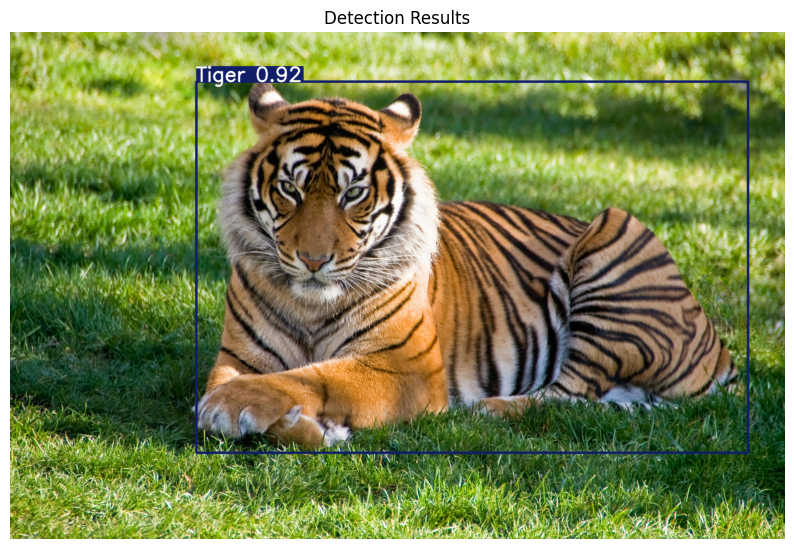

In [15]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the saved YOLOv8 model
model = YOLO('/content/drive/MyDrive/animals-dataset-processed/yolov8n/weights/best.pt')  # Replace with the path to your saved model

# Test on a single image
image_path = '/content/test.jpg'  # Replace with your image path
results = model(image_path)

# Display the results
#results.render()  # Render detections on the image
output_image = results[0].plot()  # Get the annotated image

# Show the image with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')
plt.title('Detection Results')
plt.show()